In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Import MINST data (Automatically downloads if the data doesn't exist)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
# Visualize Dataset
train_img   = mnist.train.images
train_label = mnist.train.labels
val_img = mnist.validation.images
val_label = mnist.validation.labels
test_img    = mnist.test.images
test_label  = mnist.test.labels

print("Training Data")
print(np.shape(train_img))
print(np.shape(train_label))
print ("Validation Data")
print (np.shape(val_img))
print (np.shape(val_label))
print ("Test Data")
print (np.shape(test_img))
print (np.shape(test_label))

n_train = np.shape(train_img)[0]
n_val = np.shape(val_img)[0]
n_test = np.shape(test_img)[0]

Training Data
(55000, 784)
(55000, 10)
Validation Data
(5000, 784)
(5000, 10)
Test Data
(10000, 784)
(10000, 10)


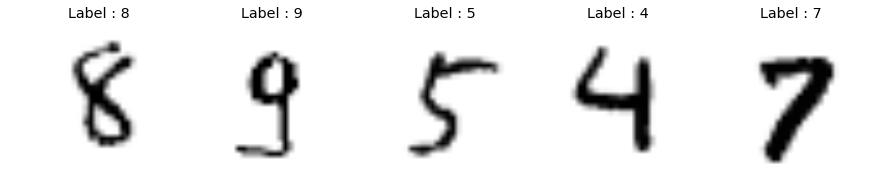

In [3]:
# Display Sample Train Images
num_show = 5
show_ind = np.random.permutation(n_train)[0:num_show]

fig = plt.figure()
for i in range(num_show):
    a=fig.add_subplot(1,num_show,i+1)
    content_img = train_img[show_ind[i],:].reshape(28,28)
    imgplot = plt.imshow(content_img, cmap='Greys')
    a.set_title('Label : ' + str(np.nonzero(train_label[show_ind[i],:])[0][0]))
    plt.axis('off')


In [4]:
# Parameters
learning_rate = 0.001
training_iters = 20000
batch_size = 128
display_step = 10

# Network Parameters
dim_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, dim_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [5]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [6]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

In [7]:
# Launch the graph
start_time = time.time()

with tf.Session() as sess:
    with tf.device("/gpu:0"):
        sess.run(init)
        step = 1
        # Keep training until reach max iterations
        while step * batch_size < training_iters:
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            if step % display_step == 0:
                # Calculate batch loss and accuracy
                loss, acc = sess.run([cost, accuracy], feed_dict={x: mnist.validation.images, 
                                                                  y: mnist.validation.labels, keep_prob: 1.})
                batch_loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
                print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.5f}".format(batch_loss) 
                      + ", Validation Accuracy= " + "{:.5f}".format(acc))
            step += 1
        print("Training Finished!")

        # Calculate accuracy for test images
        test_pred, test_acc = sess.run([pred, accuracy], feed_dict={x: mnist.test.images, 
                                                                    y: mnist.test.labels, keep_prob: 1.})
        print("Testing Accuracy:", test_acc)
        
print("--- Training Time : %s ---" % (time.time() - start_time))

Iter 1280, Minibatch Loss= 10846.67285, Validation Accuracy= 0.45900
Iter 2560, Minibatch Loss= 7820.82031, Validation Accuracy= 0.63400
Iter 3840, Minibatch Loss= 8214.91406, Validation Accuracy= 0.68100
Iter 5120, Minibatch Loss= 4763.71191, Validation Accuracy= 0.80240
Iter 6400, Minibatch Loss= 2295.14526, Validation Accuracy= 0.83120
Iter 7680, Minibatch Loss= 4540.29736, Validation Accuracy= 0.84880
Iter 8960, Minibatch Loss= 2116.86621, Validation Accuracy= 0.84820
Iter 10240, Minibatch Loss= 1886.01172, Validation Accuracy= 0.87500
Iter 11520, Minibatch Loss= 1440.16113, Validation Accuracy= 0.88140
Iter 12800, Minibatch Loss= 2150.27075, Validation Accuracy= 0.88340
Iter 14080, Minibatch Loss= 889.12866, Validation Accuracy= 0.90400
Iter 15360, Minibatch Loss= 1394.48621, Validation Accuracy= 0.89820
Iter 16640, Minibatch Loss= 867.74719, Validation Accuracy= 0.90900
Iter 17920, Minibatch Loss= 744.39246, Validation Accuracy= 0.90380
Iter 19200, Minibatch Loss= 237.56192, Vali

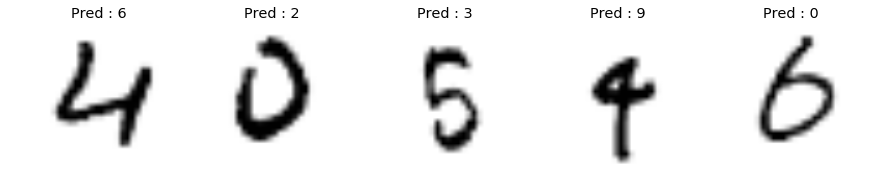

In [8]:
# Show Mis-classified Examples
lab_argmax = np.argmax(test_label, axis=1)
pred_argmax = np.argmax(test_pred, axis=1)
err_ind = list(np.where(lab_argmax != pred_argmax)[0])

num_err_show = 5
show_err_ind = np.random.permutation(len(err_ind))[0:num_err_show]

fig = plt.figure()
for i in range(num_err_show):
    a=fig.add_subplot(1,num_show,i+1)
    content_img = test_img[err_ind[show_err_ind[i]],:].reshape(28,28)
    imgplot = plt.imshow(content_img, cmap='Greys')
    a.set_title('Pred : ' + str(pred_argmax[err_ind[show_err_ind[i]],]))
    plt.axis('off')